In [2]:
%%capture --no-stderr
%pip install langgraph langchain-google-genai langchain-community langchain-core tavily-python

In [3]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "learn_agentic_ai"

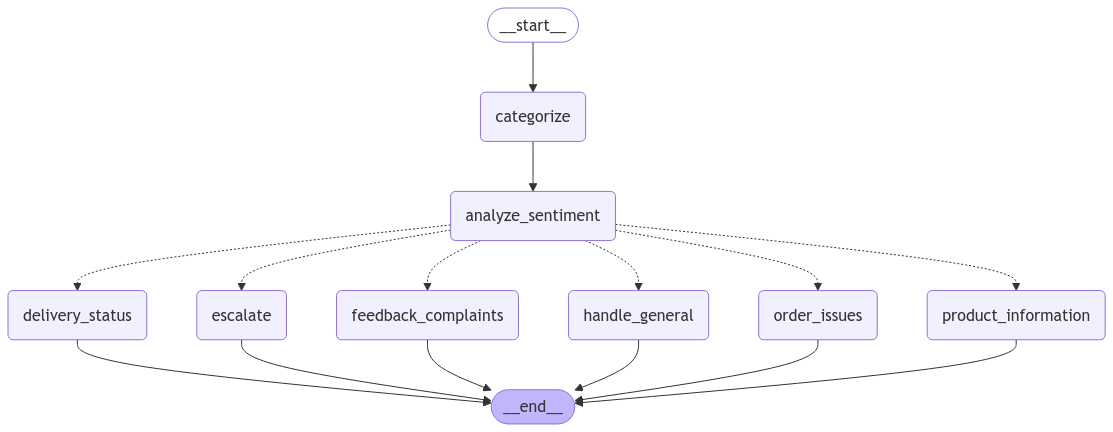

In [4]:
# from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, AnyMessage
from pydantic import BaseModel, Field
from langgraph.graph.message import add_messages
from langchain.prompts import ChatPromptTemplate
# from langgraph.checkpoint.memory import MemorySaver
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated, List
from typing_extensions import TypedDict
from IPython.display import Image, display


llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(api_key=GEMINI_API_KEY, model="gemini-1.5-flash", temperature=0)

class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    category: str
    sentiment: str
    response: str

def categorize(state: State) -> State:
    """
    Determines the category of the customer query from predefined categories:
    - Order Issues
    - Delivery Status
    - Product Information
    - Feedback / Complaints
    - Handle General
    """
    print("categorize node is working")

    class CategorizeOutput(BaseModel):
        category: str = Field(description="One of the predefined categories: Order Issues, Delivery Status, Product Information, Feedback / Complaints, Handle General")

    structured_llm = llm.with_structured_output(CategorizeOutput)

    prompt = ChatPromptTemplate.from_template(
        """Categorize the following customer query into one of these categories:
        - Order Issues
        - Delivery Status
        - Product Information
        - Feedback / Complaints
        - Handle General

        The user message is: {query}
        """
    )
    output = structured_llm.invoke(prompt.format(query=state["messages"]))
    return {"category": output.category}


def analyze_sentiment(state: State) -> State:
    """
    Evaluates the sentiment of the customer query as one of the following options:
    - Positive
    - Neutral
    - Negative
    """
    print("analyze_sentiment node is working")

    class SentimentOutput(BaseModel):
        sentiment: str = Field(description="The sentiment of the query: Positive, Neutral, or Negative")

    structured_llm = llm.with_structured_output(SentimentOutput)

    prompt = ChatPromptTemplate.from_template(
        """Analyze the sentiment of the following customer query.
        Respond with either 'Positive', 'Neutral', or 'Negative'.

        The user message is: {query}
        """
    )
    output = structured_llm.invoke(prompt.format(query=state["messages"]))
    return {"sentiment": output.sentiment}


def order_issues(state: State) -> State:
    """
    Generates a response to customer queries categorized as 'Order Issues'.
    """
    print("order_issues node is working")

    class OrderIssuesOutput(BaseModel):
        response: str = Field(description="Response to the customer's order issue query")

    structured_llm = llm.with_structured_output(OrderIssuesOutput)

    prompt = ChatPromptTemplate.from_template(
        """Provide a response to the following order issue query: {query}
        """
    )
    output = structured_llm.invoke(prompt.format(query=state["messages"]))
    return {"response": output.response}


def delivery_status(state: State) -> State:
    """
    Generates a response to customer queries categorized as 'Delivery Status'.
    """
    print("delivery_status node is working")

    class DeliveryStatusOutput(BaseModel):
        response: str = Field(description="Response to the customer's delivery status query")

    structured_llm = llm.with_structured_output(DeliveryStatusOutput)

    prompt = ChatPromptTemplate.from_template(
        """Provide a response to the following delivery status query: {query}
        """
    )
    output = structured_llm.invoke(prompt.format(query=state["messages"]))
    return {"response": output.response}

def product_information(state: State) -> State:
    """
    Generates a response to customer queries categorized as 'Product Information'.
    """
    print("product_information node is working")

    class ProductInformationOutput(BaseModel):
        response: str = Field(description="Response to the customer's product information query")

    structured_llm = llm.with_structured_output(ProductInformationOutput)

    prompt = ChatPromptTemplate.from_template(
        """Provide information about the product based on the following query: {query}
        """
    )
    output = structured_llm.invoke(prompt.format(query=state["messages"]))
    return {"response": output.response}

def feedback_complaints(state: State) -> State:
    """
    Generates a response to customer queries categorized as 'Feedback / Complaints'.
    """
    print("feedback_complaints node is working")

    class FeedbackComplaintsOutput(BaseModel):
        response: str = Field(description="Response to the customer's feedback or complaints query")

    structured_llm = llm.with_structured_output(FeedbackComplaintsOutput)

    prompt = ChatPromptTemplate.from_template(
        """Provide a response to the following feedback or complaints query: {query}
        """
    )
    output = structured_llm.invoke(prompt.format(query=state["messages"]))
    return {"response": output.response}

def handle_general(state: State) -> State:
    """
    Generates a response to customer queries categorized as 'General'.
    """
    print("handle_general node is working")

    class HandleGeneralOutput(BaseModel):
        response: str = Field(description="Response to the customer's general query")

    structured_llm = llm.with_structured_output(HandleGeneralOutput)

    prompt = ChatPromptTemplate.from_template(
        """Provide a general support response to the following query: {query}
        """
    )

    output = structured_llm.invoke(prompt.format(query=state["messages"]))
    return {"response": output.response}

def escalate(state: State) -> State:
    """
    Escalates the query to a human agent when the sentiment is negative.
    """
    print("escalate node is working")
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

def route_query(state: State) -> str:
    """
    Determines the next node to route the query based on its sentiment and category.
    """
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Order Issues":
        return "order_issues"
    elif state["category"] == "Delivery Status":
        return "delivery_status"
    elif state["category"] == "Feedback / Complaints":
        return "feedback_complaints"
    elif state["category"] == "Product Information":
        return "product_information" # Route to the new node
    else:
        return "handle_general"

graph_builder = StateGraph(State)

graph_builder.add_node("categorize", categorize)
graph_builder.add_node("analyze_sentiment", analyze_sentiment)
graph_builder.add_node("order_issues", order_issues)
graph_builder.add_node("delivery_status", delivery_status)
graph_builder.add_node("product_information", product_information)
graph_builder.add_node("feedback_complaints", feedback_complaints)
graph_builder.add_node("handle_general", handle_general)
graph_builder.add_node("escalate", escalate)

graph_builder.add_edge(START, "categorize")
graph_builder.add_edge("categorize", "analyze_sentiment")
graph_builder.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "escalate": "escalate",
        "order_issues": "order_issues",
        "delivery_status": "delivery_status",
        "feedback_complaints": "feedback_complaints",
        "handle_general": "handle_general",
        "product_information": "product_information"
    }
)
graph_builder.add_edge("order_issues", END)
graph_builder.add_edge("delivery_status", END)
graph_builder.add_edge("product_information", END)
graph_builder.add_edge("feedback_complaints", END)
graph_builder.add_edge("handle_general", END)
graph_builder.add_edge("escalate", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
def test_langgraph_agent(query: str):
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "category": "",
        "sentiment": "",
        "response": ""
    }

    output = graph.invoke(initial_state)

    print("Query:", query)
    print("Category:", output["category"])
    print("Sentiment:", output["sentiment"])
    print("Response:", output["response"])

test_queries = [
    "I need help with a refund for my order.",
    "When will my package arrive?",
    "Can you provide more details about this product?",
    "I have a complaint about the quality of the product.",
    "What are your business hours?",
    "The delivery time mentioned seems incorrect, can you confirm?",
    "I am unhappy with the response I received from customer service.",
]

for query in test_queries:
    print("\n--- Testing Query ---")
    test_langgraph_agent(query)


--- Testing Query ---
categorize node is working
analyze_sentiment node is working
order_issues node is working
Query: I need help with a refund for my order.
Category: Order Issues
Sentiment: Neutral
Response: I'm sorry you are having trouble with your refund.  Could you please provide your order number so I can assist you further?

--- Testing Query ---
categorize node is working
analyze_sentiment node is working
delivery_status node is working
Query: When will my package arrive?
Category: Delivery Status
Sentiment: Neutral
Response: Your package will arrive tomorrow

--- Testing Query ---
categorize node is working
analyze_sentiment node is working
product_information node is working
Query: Can you provide more details about this product?
Category: Product Information
Sentiment: Neutral
Response: More details about the product are not available at this moment.

--- Testing Query ---
categorize node is working
analyze_sentiment node is working
escalate node is working
Query: I have 

analyze_sentiment node is working
delivery_status node is working
Query: The delivery time mentioned seems incorrect, can you confirm?
Category: Delivery Status
Sentiment: Neutral
Response: I apologize for the inconvenience. I'm checking on the delivery time and will get back to you shortly with an update.

--- Testing Query ---
categorize node is working
analyze_sentiment node is working
escalate node is working
Query: I am unhappy with the response I received from customer service.
Category: Feedback / Complaints
Sentiment: Negative
Response: This query has been escalated to a human agent due to its negative sentiment.
